<a href="https://colab.research.google.com/github/Mbatiany/Week9_Core/blob/main/Brendah_WK9_Core_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1.Introduction##
###Overview###
This week's project requires us to implement a K-nearest neighbor (kNN) classifier  and a Naive Bayes classifier. Once we conduct the experiments, we will calculate the resulting metrics:

###1.1 Research Question###
We are expected to use KNN to predict whether a passenger aboard the Titanic survived or not.

###1.2 Metric for Success###
Our model would be considered a success if it is able to compute an accuracy score of at least 80%.

###1.3 Context###
The RMS Titanic was a British ship that crashed into an iceberg and led to the untimely demise of hundreds of passengers on its maiden voyage in April 1912.

###1.4 Experimental Design###
1.Prepare dataset(s) and clean them

2.Carry out exhaustive EDA

3.Carry out modelling using KNN

4.Optimize the KNN model

5.Challenge the Solution

6.Document everything.

###1.5 Appropriateness of Data###
I found the data to be very appropriate for the task. However, in some cases, it would have been better if the variables were a bit more clear. For example, on the 'Parch' variable, I did not understand whether it meant that the passenger had a parent or a child with them or both. The same can be said for the 'SibSp' variable.

##2.Data Preparation & Cleaning##


In [3]:
# Importing Libraries we will use for this project analysis

import pandas as pd  # for data processing
import numpy as np  # for numerical calculations


# Data Visualization Libraries
import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

# 
import requests
from io import StringIO
import pandas_profiling as pp

# Sklearn libraries for data preparartion and performance measures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, normalize, Normalizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

# Algorithms
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
# loading & previewing train dataset
train = pd.read_csv('train.csv', index_col = 'PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.tail(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q




We need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them.



In [6]:
# dropping Name, Ticket, and Cabin since I consider them useless when it comes
# to determining whether or not someone will survive
train.drop(columns = ['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [7]:
# viewing summary information for our train set

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [8]:
# checking for unique values 

cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for col in cols:
  print(col)
  print(train[col].unique())
  print('\n')

Pclass
[3 1 2]


Sex
['male' 'female']


SibSp
[1 0 3 4 2 5 8]


Parch
[0 1 2 5 3 4 6]


Embarked
['S' 'C' 'Q' nan]




In [9]:
# Summary statistics of the two sets
# 
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that;

 -38% out of the training-set survived the Titanic.

 -passenger ages range from 0.4 to 80.



In [10]:
# checking the columns names

train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [11]:
train.shape

(891, 8)

In [12]:
# dropping duplicates, if any
train = train.drop_duplicates()
print("New 'train' dataset shape:", train.shape)


New 'train' dataset shape: (780, 8)


In [13]:
# checking for null values
print(train.isna().sum())
print("\n")


Survived      0
Pclass        0
Sex           0
Age         104
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64




The 'train' dataset is missing 2 values in its Embarked column.

In [14]:
train = train.dropna(subset = ['Embarked'])
print("Missing values in train's Embarked column:", train.Embarked.isna().any())


Missing values in train's Embarked column: False


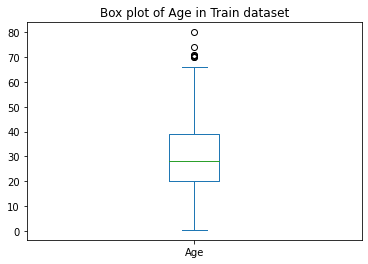

In [15]:
ds = [train]
train.name = 'Train'
for data in ds:
    data.Age.plot(kind = "box")
    plt.title("Box plot of Age in {} dataset".format(data.name))
    plt.show()

The dataset does not have many outliers so the missing values will be replaced with  mean.



In [16]:
train = train.fillna(train.Age.mean())
print("Missing values in Train dataset:")
print(train.isna().any())


Missing values in Train dataset:
Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool


Our dataset now has been cleaned of all missing values.



In [17]:
train = train.astype({'Age' : 'int'})


In [18]:
# dropping extra duplicates, if any were created
train = train.drop_duplicates()
print("New 'train' dataset shape:", train.shape)


New 'train' dataset shape: (772, 8)


In [19]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()

# columns to encode
to_encode = ['Sex', 'Embarked']

# dictionary to store each unique variable class
class_dict = {}

for item in to_encode:
    encoder = LabelEncoder().fit(train[item].unique())
    classed = encoder.classes_
    class_dict[item] = classed
    # encoding in 'train' dataset
    train[item] = encoder.transform(train[item].values)

# to decode, use the following structure
class_dict['Sex'][0]

'female'

In [20]:
# change Survived from float to category
train = train.astype({'Survived' : 'category'})
train.Survived.dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [21]:
# dropping duplicates, if any are present
train = train.drop_duplicates()
print("New dataset shape:", train.shape)

New dataset shape: (772, 8)


No new duplicates were created so none were dropped.



In [22]:
# saving our cleaned datasets
train.to_csv('train_cleaned.csv', index = False)

# train = pd.read_csv('train_cleaned.csv')


##3.Exploratory Data Analysis##


###3.1. Univariate Analysis###


In [23]:
train.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,2.244819,0.625648,29.641192,0.531088,0.422280,34.914545,1.524611
std,0.854324,0.484269,13.735863,0.991700,0.841789,52.432816,0.807337
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,8.050000,1.000000
50%,3.000000,1.000000,29.000000,0.000000,0.000000,16.100000,2.000000
75%,3.000000,1.000000,36.000000,1.000000,1.000000,34.375000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17385eec50>,
      dtype=object)

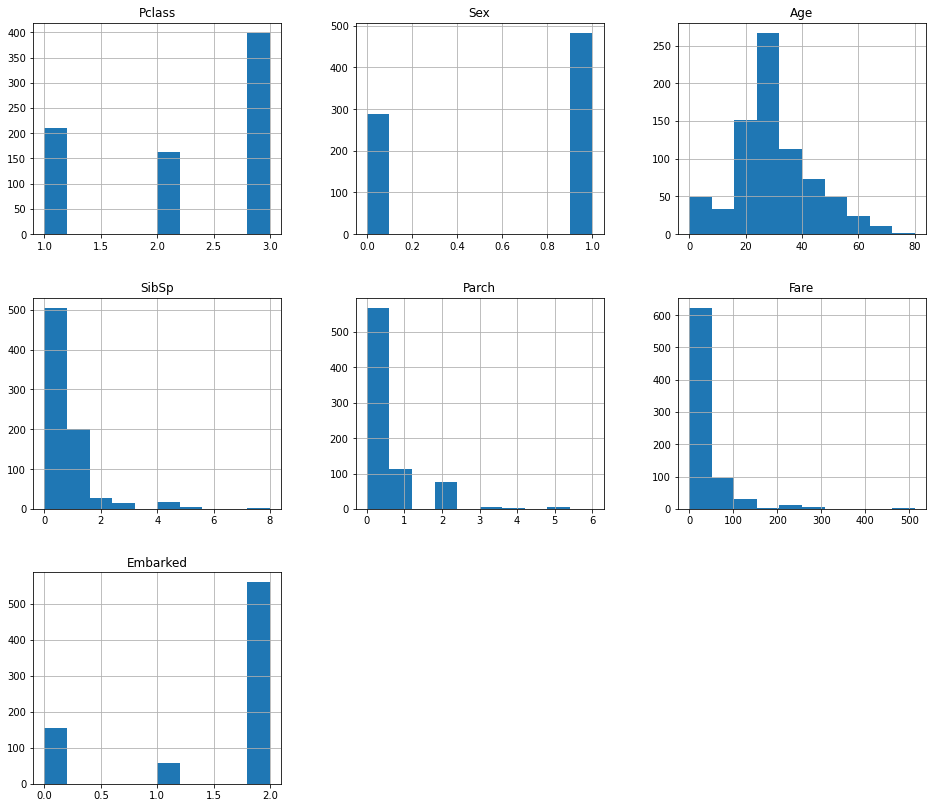

In [26]:
train.hist(figsize = [16, 14])


From the diagram;

*the age range is from 0 to 80 with most of the passengers being between 22-32 years of age

*most of them embarked at location S (code 2)

*most of them paid fare of between 0 to around 50

*0 is the most common value for the Parch variable followed by 1

*most of the passengers were in 3rd class

*there were more men than women

*the most common value for the SibSp variable is 0 followed by 1

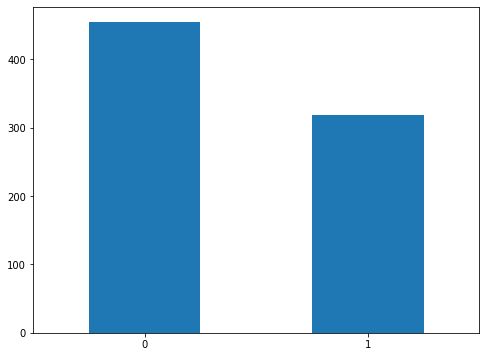

In [27]:
# viewing the countplot of those who survived vs those who didn't
train.Survived.value_counts().plot(kind = 'bar', rot = 0, figsize = [8, 6])

Most passengers did not survive.


In [28]:
# gender distribution
train.Sex.value_counts()

1    483
0    289
Name: Sex, dtype: int64

716 of the passengers were males while 433 were females.



In [29]:
# distribution of passengers across classes
train.Pclass.value_counts()

3    399
1    210
2    163
Name: Pclass, dtype: int64

Majority of the passengers were in 3rd class (399) followed by those in 1st class (210) followed by 2nd class (163).



In [30]:
# distribution across point of embarkment
train.Embarked.value_counts()

2    560
0    155
1     57
Name: Embarked, dtype: int64

In [31]:
print("2:", class_dict['Embarked'][2])
print("0:", class_dict['Embarked'][0])
print("1:", class_dict['Embarked'][1])

2: S
0: C
1: Q


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


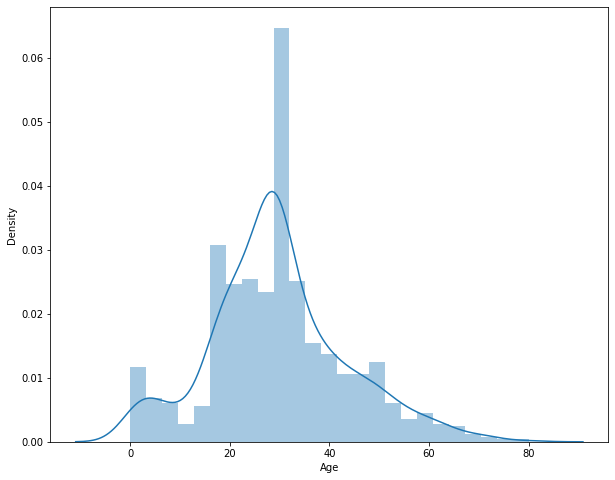

In [34]:
# distribution of age
fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(train.Age, ax = ax)

The distribution appears to be normal and leptokurtic.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


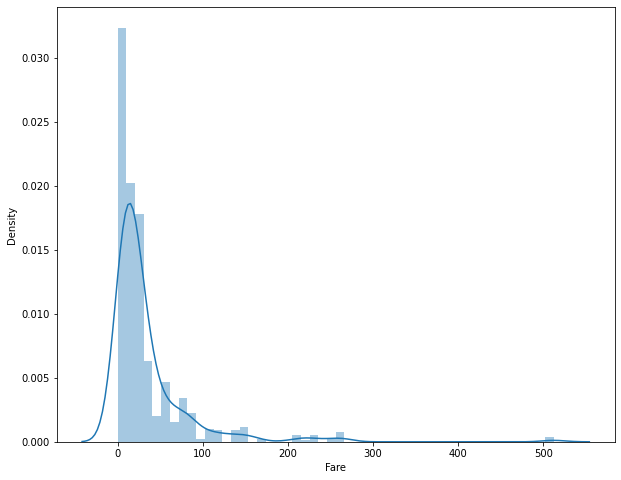

In [35]:
# fare distribution
fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(train.Fare, ax = ax)


The distribution for the Fares is positively skewed 



###3.2. Bivariate Analysis###


Survived  Sex
0         1      378
          0       76
1         0      213
          1      105
Name: Sex, dtype: int64


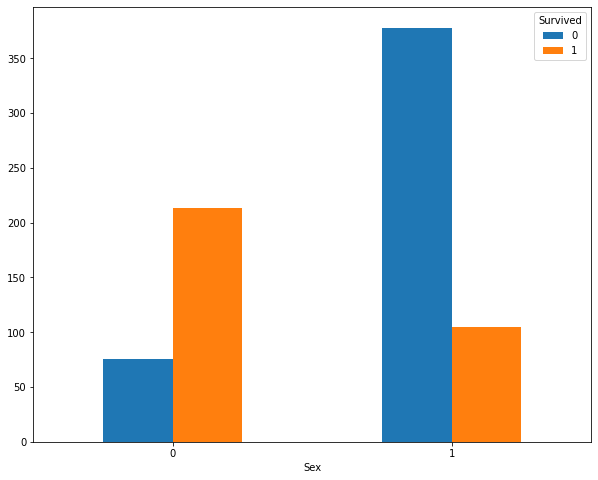

In [36]:
# survival status by sex
print(train.groupby('Survived').Sex.value_counts())
pd.crosstab(train.Sex, train.Survived).plot(kind = 'bar', rot = 0, figsize = [10, 8])

Of those who survived, majority are females (213) compared to males (105).
Of those who didn't survive, majority are males (378) compared to males (76).



Survived  Pclass
0         3         296
          2          81
          1          77
1         1         133
          3         103
          2          82
Name: Pclass, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


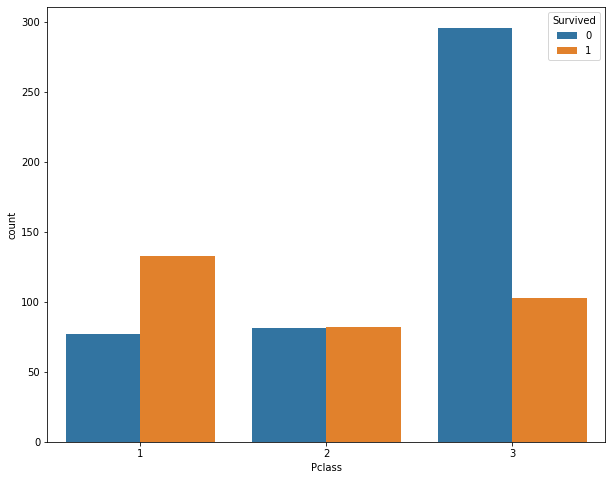

In [37]:
# survival status by class
print(train.groupby('Survived').Pclass.value_counts())

fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Survived', data = train, ax = ax)

**Survived**

 133 were in 1st class, 103 were in 3rd class and 82 were in 2nd class.

**Didn't survive**

 296 were in 3rd class, 81 were in 2nd class and 77 were in 1st class.


Survived  SibSp
0         0        313
          1         94
          2         15
          4         15
          3         10
          5          5
          8          2
1         0        192
          1        107
          2         12
          3          4
          4          3
Name: SibSp, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


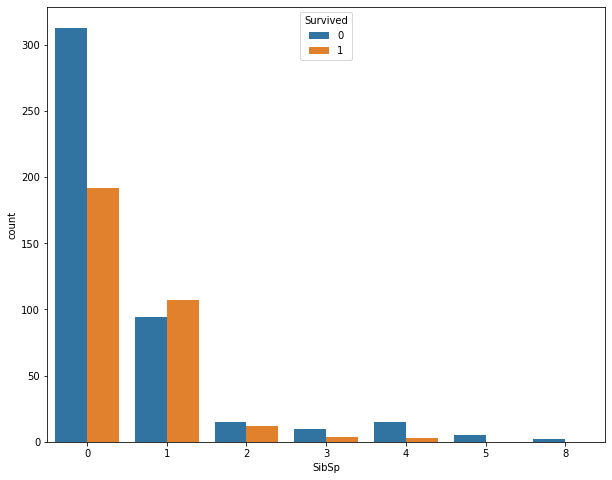

In [39]:
# survival status by siblings/spouses
print(train.groupby('Survived').SibSp.value_counts())

fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('SibSp', hue = 'Survived', data = train, ax = ax)


**Didn't survive***

*313 had neither siblings nor spouses

*94 had 1 sibling or spouse  

*15 had 2 siblings or spouses

*10 had 3 siblings or spouses 

*15 had 4 siblings or spouses

*5 had 5 siblings or spouses 

*2 had 8 siblings or spouses 

**Survived**

*192 had neither siblings nor spouses 

*107 had 1 sibling or spouse

*12 had 2 siblings or spouses 

*4 had 3 siblings or spouses 

*3 had 4 siblings or spouses 



Survived  Embarked
0         2           351
          0            65
          1            38
1         2           209
          0            90
          1            19
Name: Embarked, dtype: int64


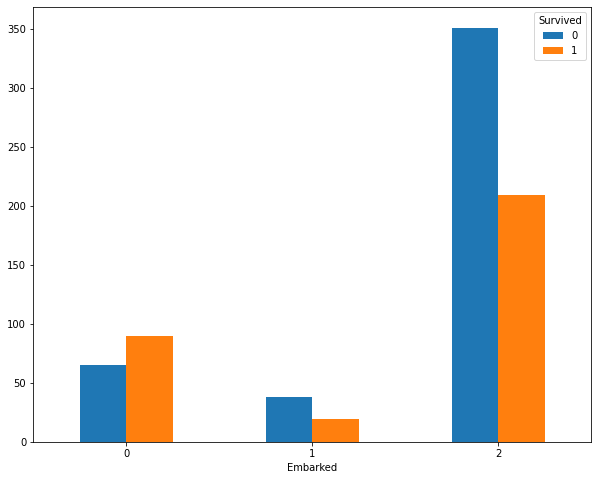

In [40]:
# survival by point of embarkment
print(train.groupby('Survived').Embarked.value_counts())
pd.crosstab(train.Embarked, train.Survived).plot(kind = 'bar', rot = 0, figsize = [10, 8])

**Survived**

351 embarked at point S, 65 embarked at point C, and 38 embarked at point Q

**Didn't Survive**

209 embarked at point S, 90 embarked at point C, and 19 embarked at point Q.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


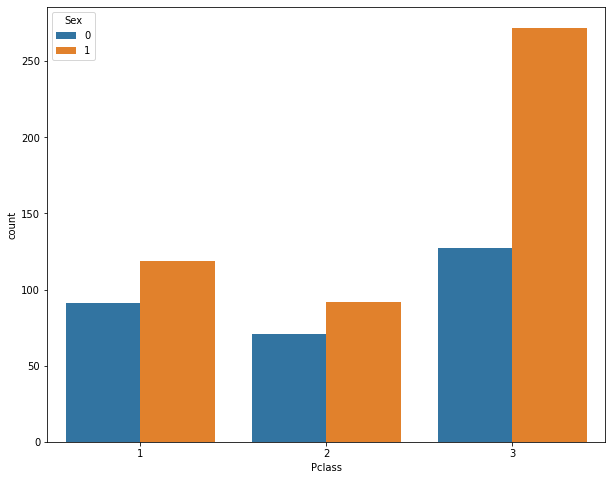

In [41]:
# class per gender
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Sex', data = train, ax = ax)

There were more males than females in all classes



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


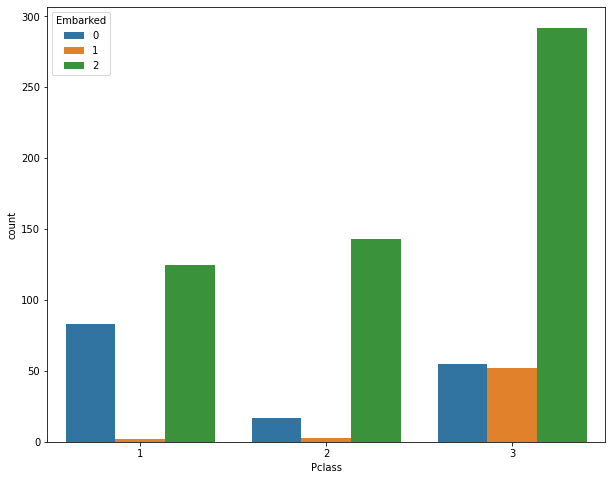

In [42]:
# class per point of embarkment
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Embarked', data = train, ax = ax)

In [43]:
# splitting age into categories to make it easier to analyze
conditions = [
    ((train.Age >= 0) & (train.Age <= 10)),
    ((train.Age >= 11) & (train.Age <= 20)),
    ((train.Age >= 21) & (train.Age <= 30)),
    ((train.Age >= 31) & (train.Age <= 40)),
    ((train.Age >= 41) & (train.Age <= 50)),
    ((train.Age >= 51) & (train.Age <= 60)),
    ((train.Age >= 61) & (train.Age <= 70)),
    ((train.Age >= 71) & (train.Age <= 80))
]
choices = ['1', '2', '3', '4', '5', '6', '7', '8']

train['Age_range'] = np.select(conditions, choices)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17381df450>],
      dtype=object)

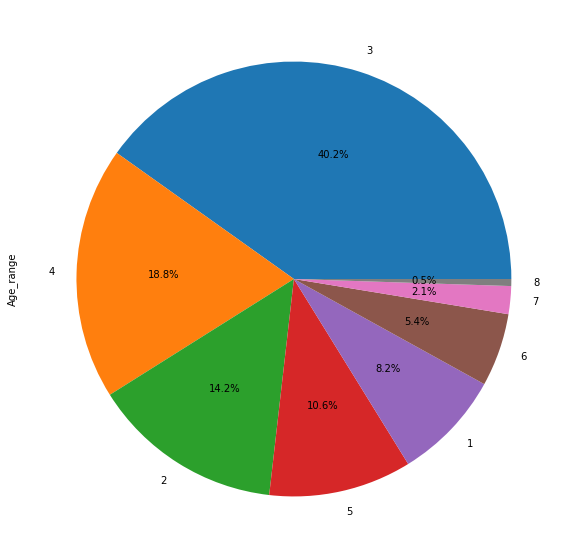

In [44]:
# plotting age ranges in a pie chart
train.Age_range.value_counts().plot(kind = 'pie', autopct = '%0.1f%%', figsize = [12, 10], 
                                      subplots = True)

age range 3 (20-30 year olds) make up the majority of the passengers while 70-80 year olds are the minority.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


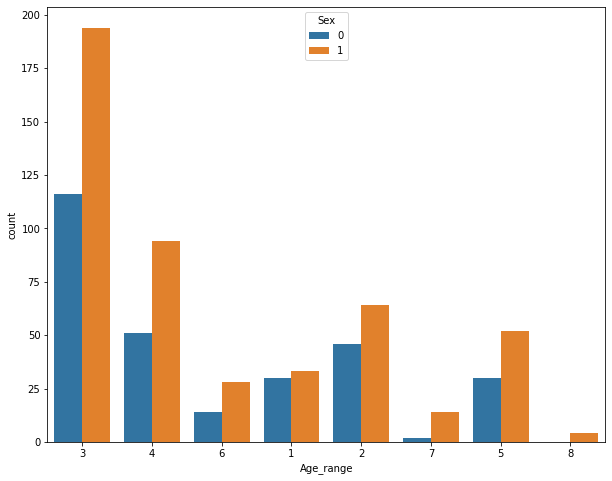

In [45]:
# age distribution per gender
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Sex', data = train, ax = ax)

There are more males than females in all the age ranges



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


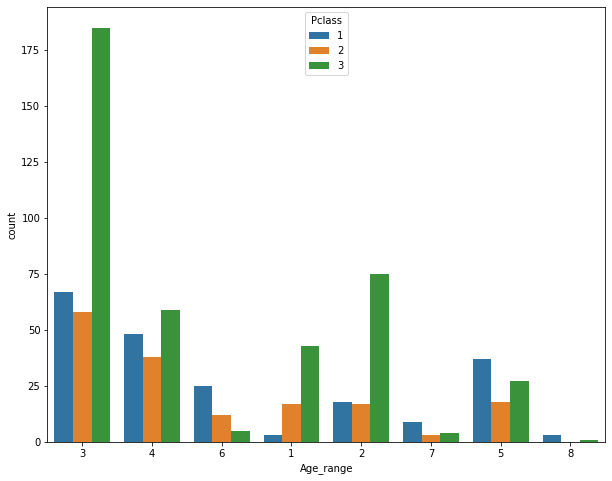

In [46]:
# age distribution per class
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Pclass', data = train, ax = ax)

Most are in 3rd class,however, 40 to 80 years of age, we see that there are more  passengers in 1st class compared to those in 3rd class.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


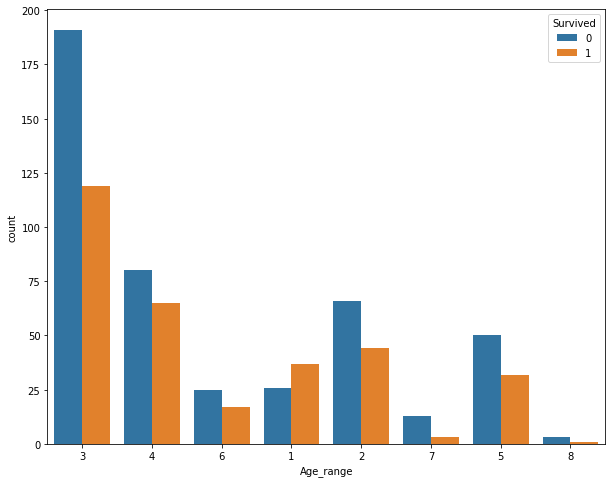

In [48]:
# survival status per age
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Survived', data = train, ax = ax)

Max fare: 512.33


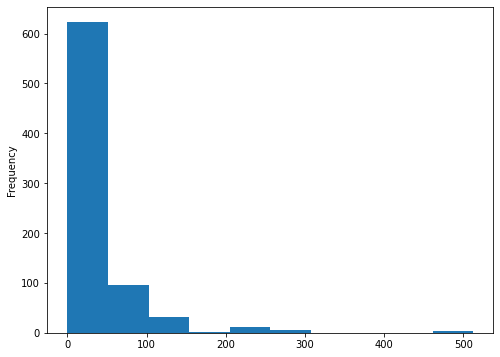

In [49]:
# to create categories for our Fare column, let's look at its distribution again
print("Max fare:", round(train.Fare.max(), 2))
train.Fare.plot(kind = 'hist', figsize = [8, 6])

In [50]:
conditions = [
    ((train.Fare >= 0) & (train.Fare <= 50)),
    ((train.Fare >= 51) & (train.Fare <= 100)),
    ((train.Fare >= 101) & (train.Fare <= 200)),
    ((train.Fare >= 201) & (train.Fare <= 300)),
    ((train.Fare >= 301) & (train.Fare <= 515))
]
choices = ['1', '2', '3', '4', '5']

train['Fare_range'] = np.select(conditions, choices)

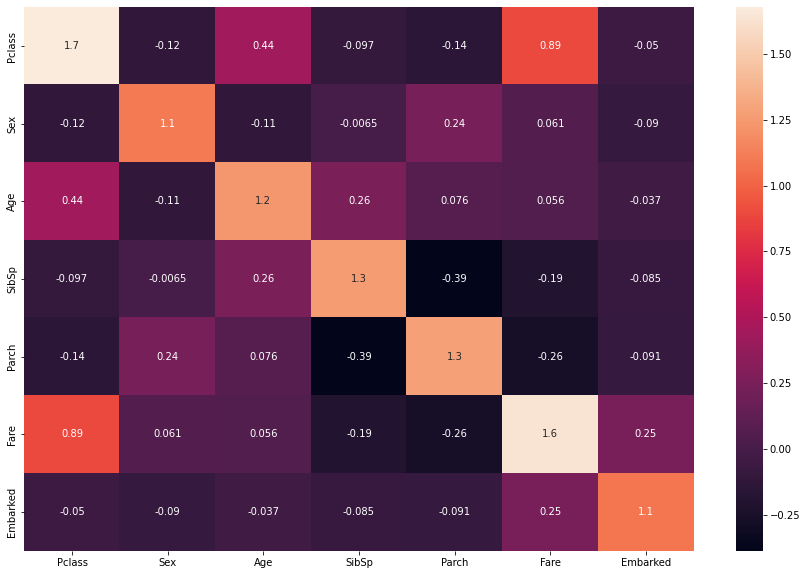

In [59]:
# checking for multicollinearity
corr = train.corr()
vif = pd.DataFrame(np.linalg.inv(corr.values), index = corr.index, columns = corr.columns)

# using a heatmap to display the results
plt.figure(figsize = (15, 10))
sns.heatmap(vif, annot = True)

All our variables have Variance Inflation Factor (VIF) scores which are nowhere near 5, which would have made them really problematic. There is no need of dropping any columns.



##4.Modeling - K Nearest Neighbor (KNN)##


In [60]:
# splitting our data into attributes and label
X = train.drop(columns = ['Survived']).values
y = train['Survived'].values
print(X.shape)
print(y.shape)

(772, 9)
(772,)


###4.1 KNN without splitting###


In [61]:
from sklearn.neighbors import KNeighborsClassifier

# fitting the classifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X, y)

# making predictions
y_pred = classifier.predict(X)

# evaluating the classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy score:",accuracy_score(y, y_pred))

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

Accuracy score: 0.7875647668393783
[[387  67]
 [ 97 221]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       454
           1       0.77      0.69      0.73       318

    accuracy                           0.79       772
   macro avg       0.78      0.77      0.78       772
weighted avg       0.79      0.79      0.79       772



We see that the accuracy of our model without splitting the data into train and test sets is 79%.



###4.2 KNN with train-test splits###

We will use a loop to loop through a list of possible test cases to determine which one provides the best accuracy.




In [62]:
my_tests = [0.1, 0.2, 0.3, 0.4, 0.5]

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

for test in my_tests:
    X_train, X_test, y_train, y_test = tts(X, y, test_size = test, random_state = 12)
    
    # scaling the training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fitting to classifier
    classifier = KNeighborsClassifier(n_neighbors = 5)
    classifier.fit(X_train, y_train)
    
    # making predictions
    y_pred = classifier.predict(X_test)

    # evaluating the algorithm
    print("Test size {} has Accuracy score:".format(test),accuracy_score(y_test, y_pred))

Test size 0.1 has Accuracy score: 0.7948717948717948
Test size 0.2 has Accuracy score: 0.7548387096774194
Test size 0.3 has Accuracy score: 0.7844827586206896
Test size 0.4 has Accuracy score: 0.7993527508090615
Test size 0.5 has Accuracy score: 0.7901554404145078


 We can see that the 60-40 split  is  more accurate than carrying out the predictions without splitting the dataset into training and testing sets.

###4.3 KNN Hyperparameter Tuning###


###4.3.1 90-10 split###


In [78]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 90-10 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.1, random_state = 12)

neighbor_range = np.arange(1, 51)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split gave an accuracy of {}".format(max_k,
                                                                                       (max_acc * 100)))

A k value of 6 for this train-test split gave an accuracy of 73.0


In [64]:
# optimizing by normalizing
from sklearn.preprocessing import Normalizer
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

from sklearn.model_selection import KFold, RandomizedSearchCV

knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [65]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.7051282051282052
[[34 13]
 [10 21]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        47
           1       0.62      0.68      0.65        31

    accuracy                           0.71        78
   macro avg       0.70      0.70      0.70        78
weighted avg       0.71      0.71      0.71        78



The accuracy score for the 90-10 split was 79.4% but after getting the best value of k,we got an accuracy of 73%.

###4.3.2 80-20 split###


In [79]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 80-20 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split gave an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 13 for this train-test split gave an accuracy of 73.0


In [67]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [68]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 39, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.6645161290322581
[[66 30]
 [22 37]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        96
           1       0.55      0.63      0.59        59

    accuracy                           0.66       155
   macro avg       0.65      0.66      0.65       155
weighted avg       0.67      0.66      0.67       155



The accuracy score for the 80-20 split was 78.7% but after getting the best value of k,we got an accuracy of 73%.



###4.3.3 70-30 split###


In [81]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 70-30 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split gave an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 20 for this train-test split gave an accuracy of 74.0


In [70]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 39, 'metric': 'manhattan'}


In [71]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.6939655172413793
[[99 44]
 [27 62]]
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       143
           1       0.58      0.70      0.64        89

    accuracy                           0.69       232
   macro avg       0.69      0.69      0.69       232
weighted avg       0.71      0.69      0.70       232



The accuracy score for the 70-30 split was 77.1% but after getting the best value of k,we got an accuracy of 74%.



###4.3.4 60-40 split###


In [82]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 60-40 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.4, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split gave an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 15 for this train-test split gave an accuracy of 72.0


In [73]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [74]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.6957928802588996
[[135  57]
 [ 37  80]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       192
           1       0.58      0.68      0.63       117

    accuracy                           0.70       309
   macro avg       0.68      0.69      0.69       309
weighted avg       0.71      0.70      0.70       309



The accuracy score for the 60-40 split was 79.6% but after getting the best value of k,we got an accuracy of 72%..

##5.Conclusion & Challenging the Solution##
To conclude, we see that the accuracy score is highest for the 60-40 split without any hyperparameter tuning (79.6%). With hyperparameter tuning, the accuracy score went down

 We will challenge our solution by applying gradient boosting.


In [75]:
# use Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# selecting 60-40 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.4, random_state = 12)

# setting different learning rates, so that we can compare the performance of 
# the classifier's performance at different learning rates
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gbc = GradientBoostingClassifier(n_estimators = 200, max_depth = 2,
                                     learning_rate = learning_rate,
                                     random_state = 12)
    gbc.fit(X_train, y_train)

    print("Learning rate:", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(X_train,
                                                                   y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gbc.score(X_test,
                                                                     y_test)))
    print("*******************************************")

Learning rate: 0.05
Accuracy score (training): 0.847
Accuracy score (validation): 0.793
*******************************************
Learning rate: 0.075
Accuracy score (training): 0.862
Accuracy score (validation): 0.796
*******************************************
Learning rate: 0.1
Accuracy score (training): 0.881
Accuracy score (validation): 0.806
*******************************************
Learning rate: 0.25
Accuracy score (training): 0.937
Accuracy score (validation): 0.799
*******************************************
Learning rate: 0.5
Accuracy score (training): 0.972
Accuracy score (validation): 0.738
*******************************************
Learning rate: 0.75
Accuracy score (training): 0.978
Accuracy score (validation): 0.744
*******************************************
Learning rate: 1
Accuracy score (training): 0.985
Accuracy score (validation): 0.709
*******************************************


The learning rate of 0.1 gives us the best performance when it comes to validating, and good performance when it comes to training so we will use it as our parameter.



In [83]:
# now to use our selected learning rate to model
grad = GradientBoostingClassifier(n_estimators = 200, max_depth = 2, 
                                  learning_rate = 0.1, random_state = 0)

# fitting to training data
grad.fit(X_train, y_train)

# making predictions
grad_y_pred = grad.predict(X_test)

# evaluating the algorithm
print("Confusion Matrix:")
print(confusion_matrix(y_test, grad_y_pred))
print("Classification Report")
print(classification_report(y_test, grad_y_pred))

Confusion Matrix:
[[161  31]
 [ 29  88]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       192
           1       0.74      0.75      0.75       117

    accuracy                           0.81       309
   macro avg       0.79      0.80      0.79       309
weighted avg       0.81      0.81      0.81       309



Accuracy has gone up to 81% by using gradient boosting, which is a slight improvement but passes the metric for success.